# Data augmentation
- Artificiellt skapa fler bilder
- slumpmässigt:
    - Roterar till en viss grad (radianer)
    - Traslatera
    - flippa horisontellt, vertiklat (Spegla)
    - Shear
    - ...

X_train.shape=(60000, 28, 28), X_test.shape=(10000, 28, 28)


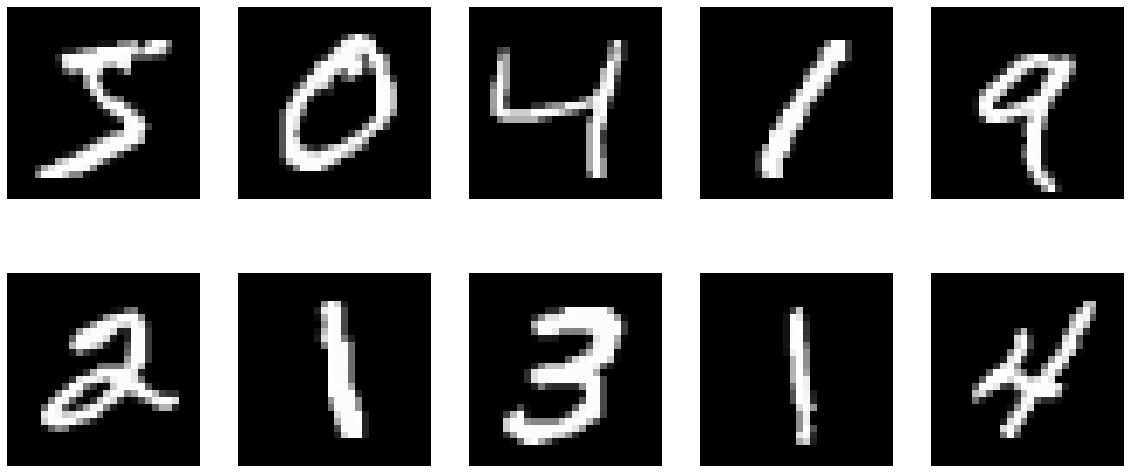

In [17]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()
print(f"{X_train.shape=}, {X_test.shape=}")
y_train = y_train.ravel()
y_test = y_test.ravel()

def plot_samples(data):
    fig, axes = plt.subplots(2,5, figsize = (20,9))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i], cmap = "gray")
        ax.axis("off")

plot_samples(X_train)
        

In [18]:
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255
X_train.min(), X_train.max()

(0.0, 1.0)

## Train | Val | Test split

In [19]:
from sklearn.model_selection import train_test_split

X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=1/6, random_state=42)

X_train_val = X_train_val[:,:,:,None]
X_train = X_train[:,:,:,None]
X_val = X_val[:,:,:,None]
X_test = X_test[:,:,:,None]

X_train_val.shape

(50000, 28, 28, 1)

## Data augmentation

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(
    rotation_range = 10,
    shear_range = .2,
    zoom_range = .1,
    horizontal_flip = False,
    height_shift_range = .2,
    width_shift_range = .2
)

# Dont augment validation and test data
test_image_generator = ImageDataGenerator()

train_val_generator = train_image_generator.flow(X_train_val, y_train_val, batch_size = 32)

val_generator = test_image_generator.flow(X_val, y_val, batch_size=32)

train_val_generator, val_generator

(<keras.preprocessing.image.NumpyArrayIterator at 0x267b6540d00>,
 <keras.preprocessing.image.NumpyArrayIterator at 0x267b65402b0>)

2
(32, 28, 28, 1)


array([4, 4, 6, 6, 1, 3, 9, 2, 7, 8, 1, 9, 9, 7, 7, 7, 4, 9, 1, 6, 7, 2,
       1, 7, 1, 1, 4, 6, 7, 9, 9, 8], dtype=uint8)

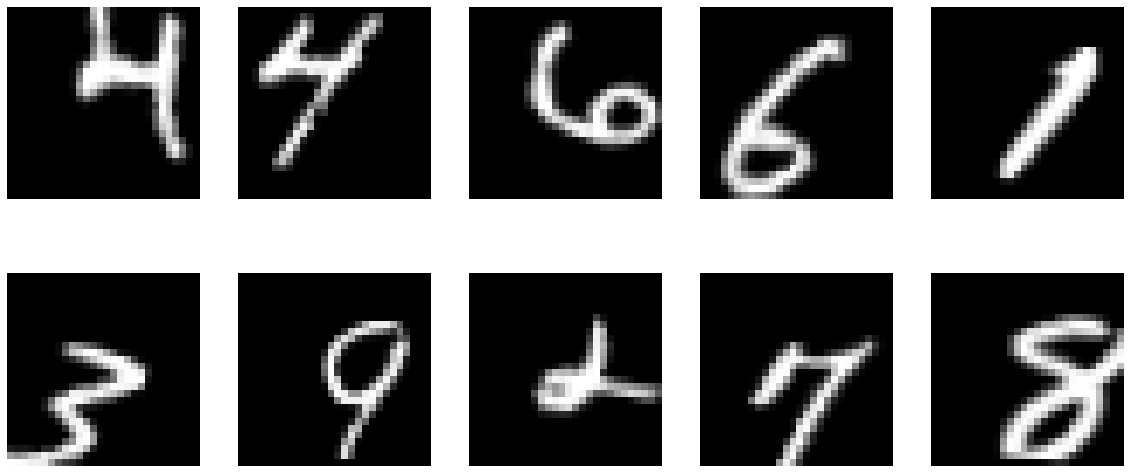

In [32]:
print(len(train_val_generator.next()))

sample_batch = train_val_generator.next()
print(sample_batch[0].shape) ## 32 smaples in a batch

plot_samples(sample_batch[0])
sample_batch[1]

## CNN model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate = .001, drop_rate = .5, kernels = [32, 32]):
    adam = Adam(learning_rate = learning_rate)

    model = Sequential(name = "CNN_model")

    ## The Convolutional layers
    for number_kernel in kernels:
        conv_layer = Conv2D(number_kernel, kernel_size = (3,3), 
                            activation = "relu", kernel_initializer = "he_normal", 
                            input_shape = X_train.shape[1:])
        
        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

    # MLP layers
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation = "relu", kernel_initializer = "he_normal"))
    model.add(Dense(10, activation = "softmax"))

    model.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = ["acc"])

    return model

model = CNN_model(drop_rate=.5)
model.summary()

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dropout (Dropout)           (None, 800)               0 